In [1]:
import pickle
import numpy as np
import scvelo as scv
import torch
import scanpy as sc
from scipy.sparse import csr_matrix
from veloproj import *

scv.settings.verbosity = 1
device = torch.device("cpu")

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '1e-5', 
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--model-name', 'dentategyrus_model.cpt',
                               '--exp-name', 'CohAE_dentategyrus',
                               '--device', 'cuda:2',
                               '--gumbsoft_tau', '5',
                               '--nb_g_src', "X",
                               '--ld_nb_g_src', "X",
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '1',
                               '--fit_offset_train', 'false',
                               '--fit_offset_pred', 'true',
                               '--use_offset_pred', 'false',
                               '--gnn_layer', 'GAT',
                               '--vis-key', 'X_umap',
                               '--vis_type_col', 'seurat_clusters',
                               '--scv_n_jobs', '10',
                              ])
args                              

Namespace(adata=None, aux_weight=1.0, conv_thred=1e-06, data_dir=None, device='cuda:2', exp_name='CohAE_dentategyrus', fit_offset_pred=True, fit_offset_train=False, g_rep_dim=100, gnn_layer='GAT', gumbsoft_tau=5.0, h_dim=256, is_half=False, k_dim=100, ld_adata='projection.h5', ld_nb_g_src='X', log_interval=100, lr=1e-05, lr_decay=0.9, mask_cluster_list=None, model_name='dentategyrus_model.cpt', n_conn_nb=30, n_epochs=20000, n_nb_newadata=30, n_raw_gene=2000, nb_g_src='X', output='./', pos_thred=0.01, pos_weight=0.0, refit=True, scv_n_jobs=10, seed=42, sl1_beta=1.0, use_norm=False, use_offset_pred=False, use_x=False, v_rg_wt=0.0, vis_key='X_umap', vis_type_col='seurat_clusters', weight_decay=0.0, z_dim=100)

In [3]:
sample = 'TC'
input_file = '/home/linxy29/holab/iPSC/veloAE/' + sample + '_seurate.h5ad'

In [4]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [5]:
cluster_edges = [("OPC", "OL")]
EXP_NAME = args.exp_name
exp_metrics = {}

In [6]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
    #tensor_x = torch.FloatTensor(adata.X).to(device)
    tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, tensor_v, xyids, device)
    return tensor_s, tensor_u, tensor_x  

In [7]:
adata = sc.read_h5ad(input_file)
scv.pp.neighbors(adata, n_neighbors=30, n_pcs=15)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata, n_pcs=15, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.8 0.2]
AnnData object with n_obs × n_vars = 8149 × 2000
    obs: 'batch', 'seurat_clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


  0%|          | 0/8149 [00:00<?, ?cells/s]

saving figure to file ./figures/scvelo_TC_scVelo.png


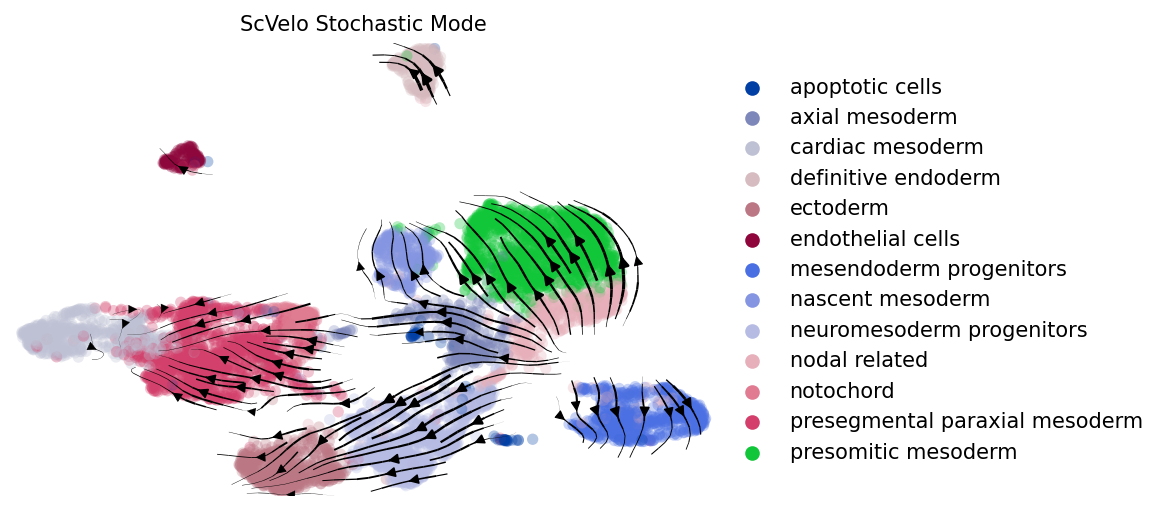

# Cross-Boundary Transition Score (A->B)
{}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{}
Total Mean: nan
# Cross-Boundary Direction Correctness (A->B)
{}
Total Mean: nan
# In-cluster Coherence
{'apoptotic cells': 0.78226656, 'axial mesoderm': 0.9491977, 'cardiac mesoderm': 0.9808267, 'definitive endoderm': 0.9483898, 'ectoderm': 0.97910607, 'endothelial cells': 0.9550546, 'mesendoderm progenitors': 0.96866363, 'nascent mesoderm': 0.95190334, 'neuromesoderm progenitors': 0.9723648, 'nodal related': 0.9646114, 'notochord': 0.96843094, 'presegmental paraxial mesoderm': 0.96854097, 'presomitic mesoderm': 0.9533485}
Total Mean: 0.949438750743866
# In-cluster Confidence
{'apoptotic cells': 0.6393390260636806, 'axial mesoderm': 0.9386669918063666, 'cardiac mesoderm': 0.9833344922021583, 'definitive endoderm': 0.9552950829562574, 'ectoderm': 0.980773458194126, 'endothelial cells': 0.9474823222255075, 'mesendoderm progenitors': 0.9721143408486379, 'nascent mesoderm': 0.95089481

AnnData object with n_obs × n_vars = 8149 × 2000
    obs: 'batch', 'seurat_clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'stc_velocity_self_transition', 'stc_velocity_length', 'stc_velocity_confidence', 'stc_velocity_confidence_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'stc_velocity_gamma', 'stc_velocity_qreg_ratio', 'stc_velocity_r2', 'stc_velocity_genes'
    uns: 'pca', 'neighbors', 'stc_velocity_params', 'stc_velocity_graph', 'stc_velocity_graph_neg', 'seurat_clusters_colors'
    obsm: 'X_umap', 'X_pca', 'stc_velocity_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu', 'stc_velocity', 'variance_stc_velocity'
    obsp: 'distances', 'connectivities'

In [8]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata,  legend_loc="right margin", vkey="stc_velocity", basis=args.vis_key, color=args.vis_type_col,
                                 dpi=150, title='ScVelo Stochastic Mode', save = sample + '_scVelo.png')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, args.vis_type_col, "stc_velocity")
adata

## Identify important genes

In [9]:
scv.tl.rank_velocity_genes(adata, groupby=args.vis_type_col, min_corr=.3, vkey='stc_velocity')
df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
## save the dataframe
df.to_csv('/home/linxy29/holab/iPSC/veloAE/' + sample + '_rank_velocity_genes.csv')
df.head()

,apoptotic cells,axial mesoderm,cardiac mesoderm,definitive endoderm,ectoderm,endothelial cells,mesendoderm progenitors,nascent mesoderm,neuromesoderm progenitors,nodal related,notochord,presegmental paraxial mesoderm,presomitic mesoderm
0,TENT5C,AP002856.2,ZNF804A,SORBS2,PTCHD4,CARMIL1,SHISA9,CACHD1,HOXB3,WNT8A,ITGB8,NECTIN3,LEF1
1,DLL1,LDB2,PRICKLE1,SMOC2,AUTS2,DCDC2,GRID2,ADAM12,RGMA,AKAP12,PDE11A,ADAMTS6,PAPPA
2,SLC2A3,LIMCH1,SOX6,PRDM1,FREM1,KCTD16,HPN,EGFLAM,NRXN1,MDK,COL11A1,RFTN2,KIF26B
3,PMAIP1,ANXA2,CTNNA3,RAB11FIP1,AC233296.1,PDE11A,ARRB1,PLXNA2,TRIM22,DLL3,DACH1,AC021504.1,NCAM1
4,FAM214A,COBL,COL11A1,PALLD,GREB1L,PCDH9,NFASC,ATAD2,NRXN3,CALD1,PCDH9,CDON,PLXNA2


saving figure to file figures/TC_apoptotic cells.png


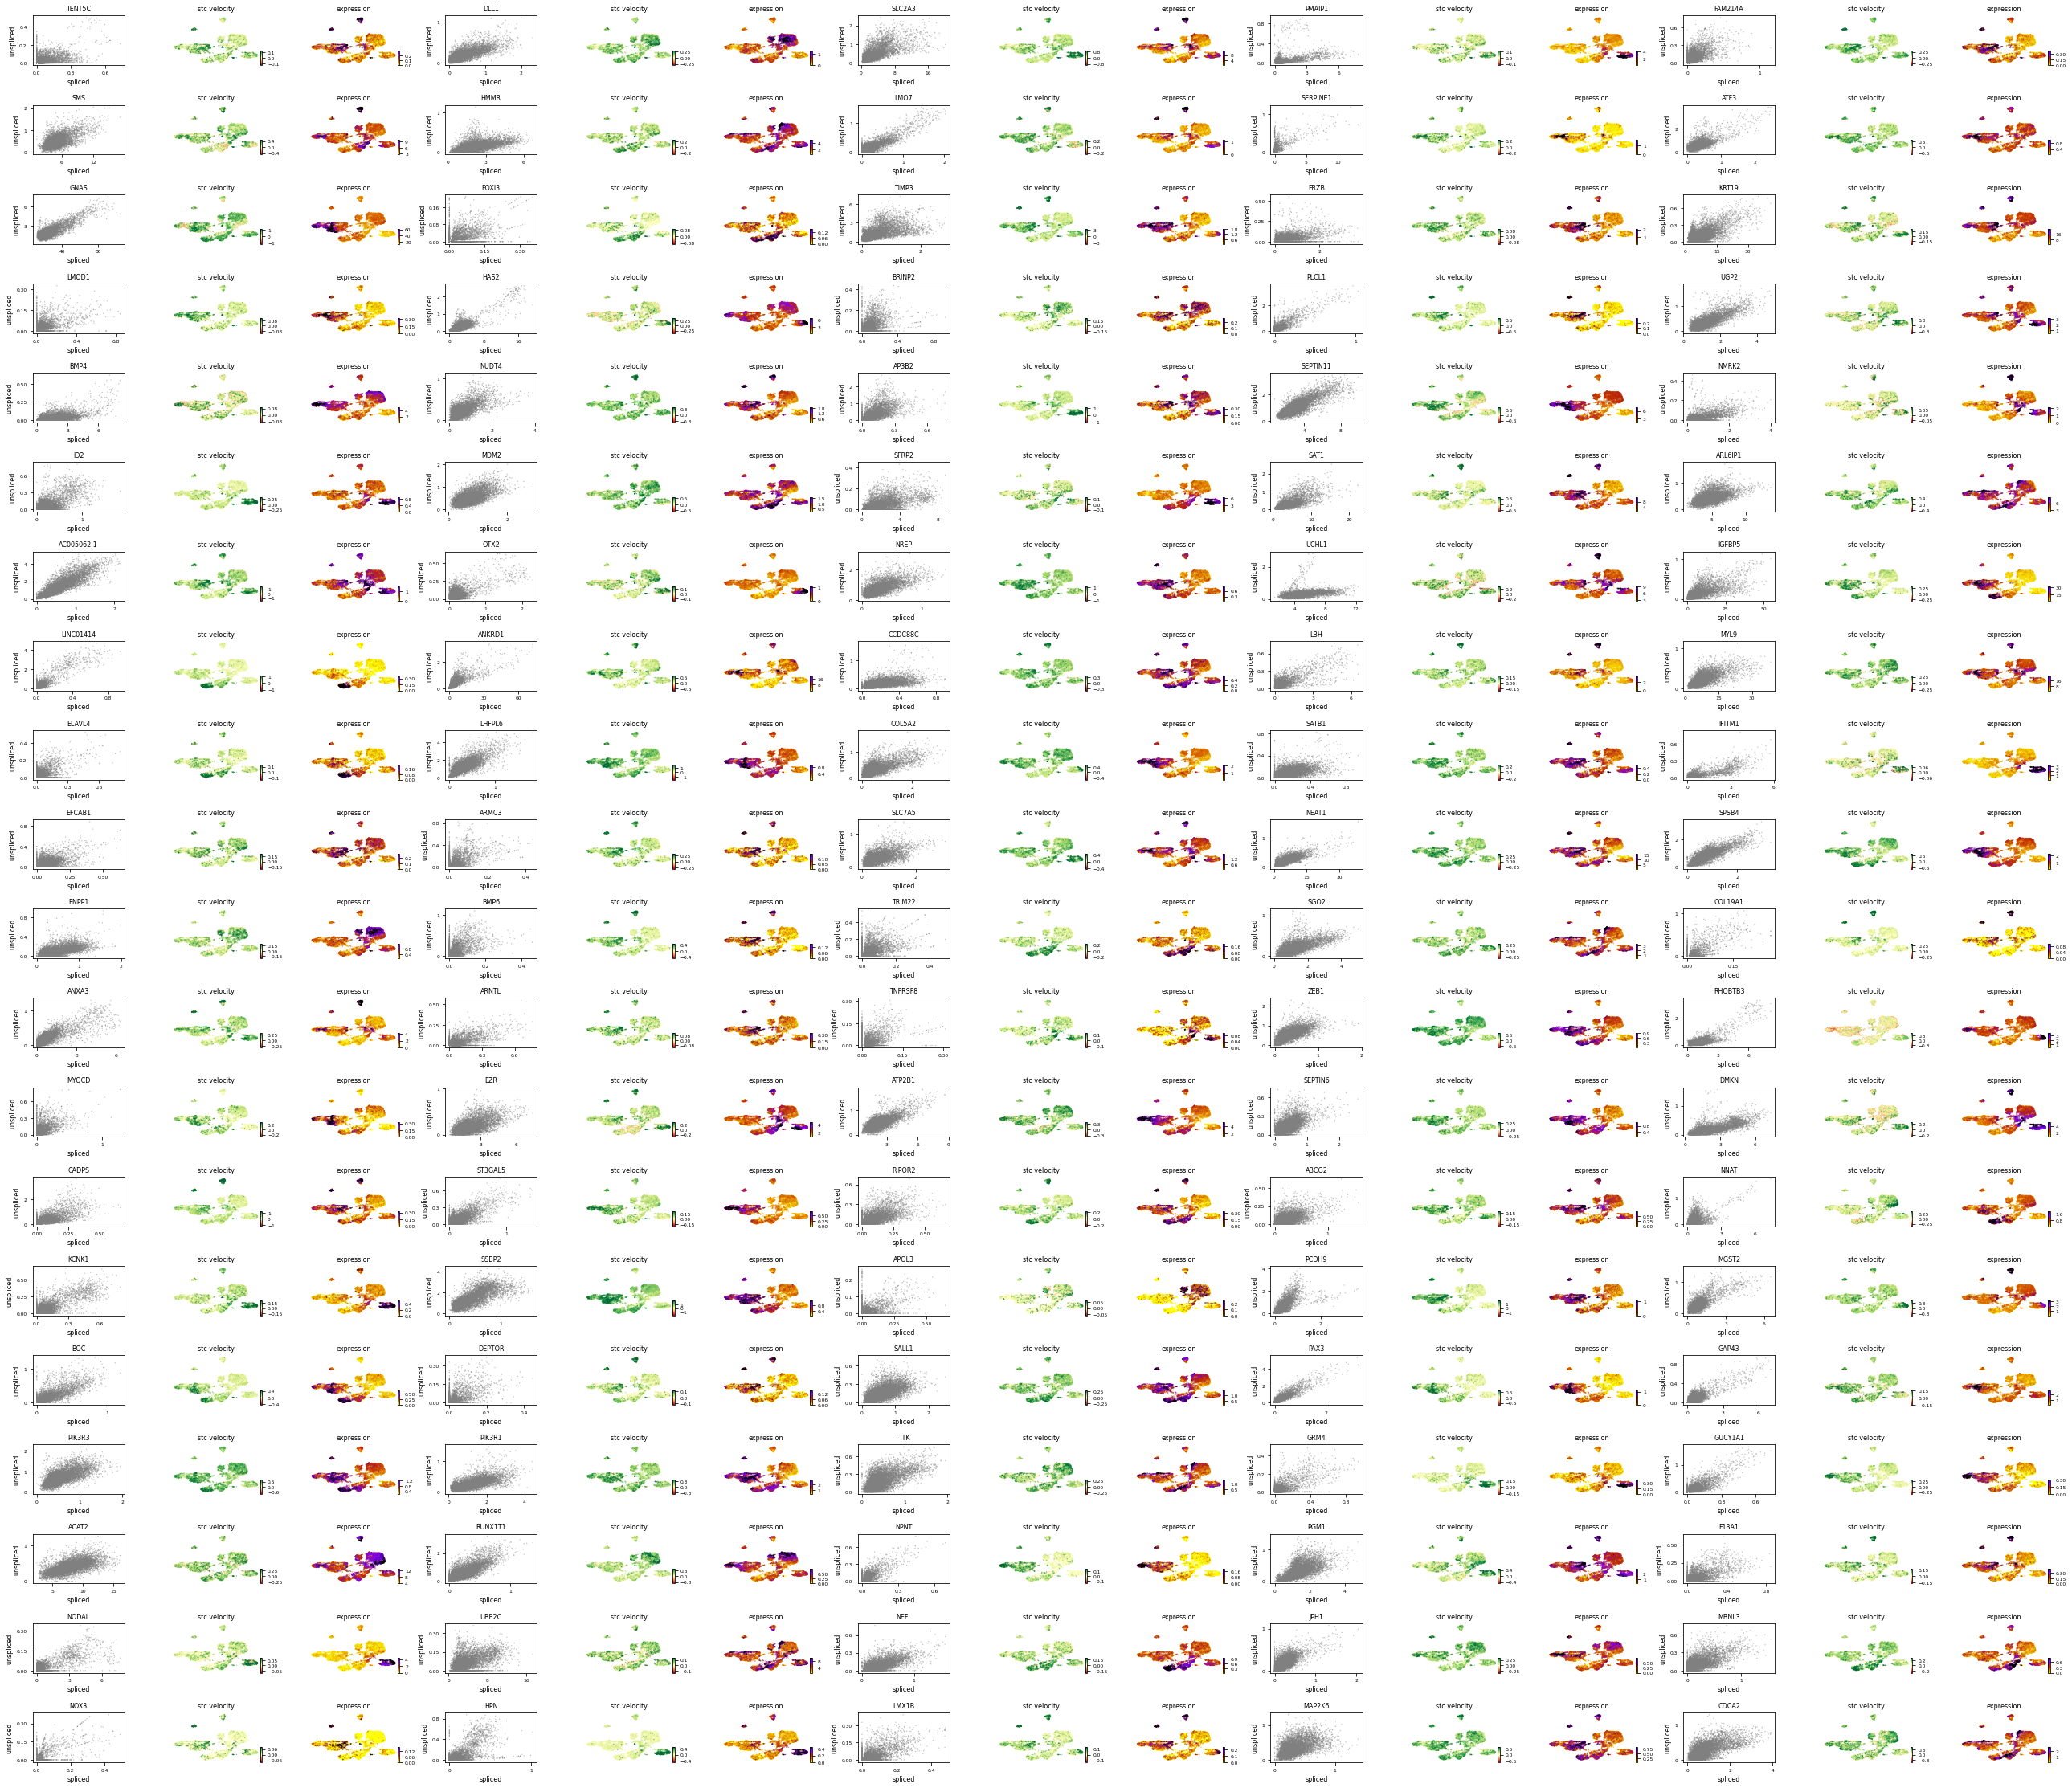

In [10]:
## plot the important genes from the dataframe
for columnName, columnData in df.iteritems():
    scv.pl.velocity(adata, columnData.values, vkey='stc_velocity', ncols=5, save = 'figures/' + sample + '_' + columnName + '.png')

In [9]:
adata.X = csr_matrix(adata.X)
adata

AnnData object with n_obs × n_vars = 22024 × 2000
    obs: 'Clusters', '_X', '_Y', 'batch', 'seurat_clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'stc_velocity_self_transition', 'stc_velocity_length', 'stc_velocity_confidence', 'stc_velocity_confidence_transition'
    var: 'Accession-0', 'Chromosome-0', 'End-0', 'Start-0', 'Strand-0', 'Accession-1', 'Chromosome-1', 'End-1', 'Start-1', 'Strand-1', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'stc_velocity_gamma', 'stc_velocity_qreg_ratio', 'stc_velocity_r2', 'stc_velocity_genes'
    uns: 'pca', 'neighbors', 'stc_velocity_params', 'stc_velocity_graph', 'stc_velocity_graph_neg', 'seurat_clusters_colors'
    obsm: 'X_umap', 'X_pca', 'stc_velocity_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu', 'stc_velocity', 'variance_stc_velocity'
    obsp: 'distances', 'connectivities'

Loss: (Total) 5.359993, (AE) 5.320724, (LR) 1.00 * 0.039270，(POS) 0.00 * 5.615151: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [44:35<00:00,  7.48it/s]]


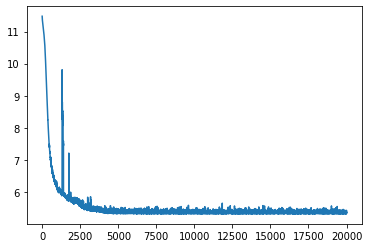

In [10]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

  0%|          | 0/22024 [00:00<?, ?cells/s]

saving figure to file ./figures/scvelo_ncc_mes_eu_veloAE.png


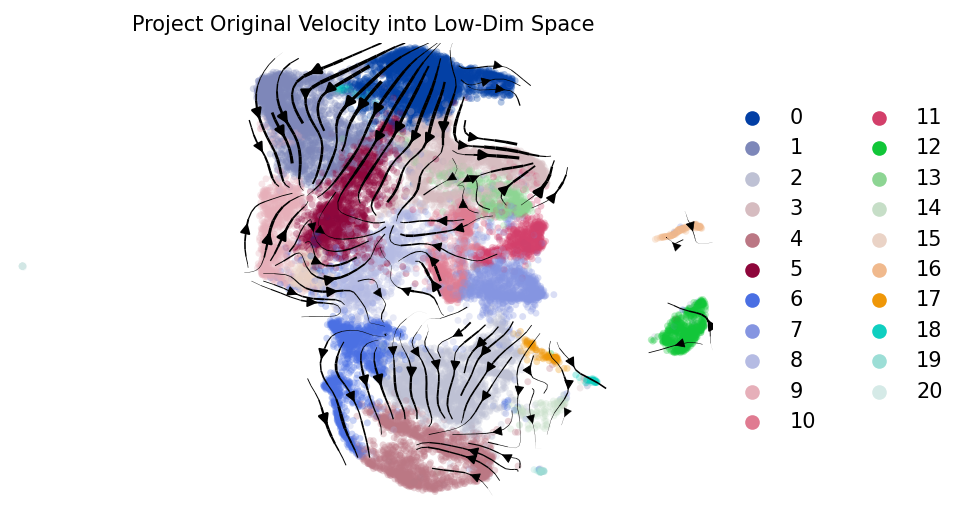

# Cross-Boundary Transition Score (A->B)
{}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{}
Total Mean: nan
# Cross-Boundary Direction Correctness (A->B)
{}
Total Mean: nan
# In-cluster Coherence
{'0': 0.9999599, '1': 0.9999063, '10': 0.99996376, '11': 0.9998104, '12': 0.9997863, '13': 0.9999197, '14': 0.9999453, '15': 0.99999034, '16': 0.9999035, '17': 0.9998494, '18': 0.9983605, '19': 0.99995536, '2': 0.9995216, '20': 0.99989396, '3': 0.99985754, '4': 0.9999475, '5': 0.99996984, '6': 0.99980104, '7': 0.9997495, '8': 0.99987686, '9': 0.99996907}
Total Mean: 0.9998066425323486
# In-cluster Confidence
{'0': 0.999956487466925, '1': 0.9998994817281149, '10': 0.9999597229045813, '11': 0.9997862450949109, '12': 0.9997598789454644, '13': 0.9999111946790841, '14': 0.999706289707086, '15': 0.9999853163434748, '16': 0.9998838333664714, '17': 0.9997923374176025, '18': 0.9986699599595297, '19': 0.9999471400913439, '2': 0.9994898884734658, '20': 0.9997705444693565, '3': 0.99984708805

In [11]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        
        spliced = adata.layers['Ms']
        unspliced = adata.layers['Mu']
        tensor_s = torch.FloatTensor(spliced).to(device)
        tensor_u = torch.FloatTensor(unspliced).to(device)
        tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)

        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                 norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                 use_offset=args.use_offset_pred).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.ld_nb_g_src, n_nb_newadata=args.n_nb_newadata)
    scv.tl.velocity_graph(adata, vkey='new_velocity', n_jobs=args.scv_n_jobs)
    scv.pl.velocity_embedding_stream(adata, legend_loc='right_margin', vkey="new_velocity", basis=args.vis_key, color=[args.vis_type_col],
                                    title="Project Original Velocity into Low-Dim Space", smooth=0.5,
                                    dpi=150,
                                    save=sample + '_veloAE.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, args.vis_type_col, "new_velocity")
exp(adata, exp_metrics)